In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt  # root-finding algorithm
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# @title Plotting Functions


def plot_fI(x, f):
  plt.figure(figsize=(6, 4))  # plot the figure
  plt.plot(x, f, 'k')
  plt.xlabel('x (a.u.)', fontsize=14)
  plt.ylabel('F(x)', fontsize=14)
  plt.show()


def plot_dr_r(r, drdt, x_fps=None):
  plt.figure()
  plt.plot(r, drdt, 'k')
  plt.plot(r, 0. * r, 'k--')
  if x_fps is not None:
    plt.plot(x_fps, np.zeros_like(x_fps), "ko", ms=12)
  plt.xlabel(r'$r$')
  plt.ylabel(r'$\frac{dr}{dt}$', fontsize=20)
  plt.ylim(-0.1, 0.1)


def plot_dFdt(x, dFdt):
  plt.figure()
  plt.plot(x, dFdt, 'r')
  plt.xlabel('x (a.u.)', fontsize=14)
  plt.ylabel('dF(x)', fontsize=14)
  plt.show()

  

In [2]:
# @markdown *Execute this cell to set default parameters for a single excitatory population model*


def default_pars_single(**kwargs):
  pars = {}

  # Excitatory parameters
  pars['tau'] = 1.     # Timescale of the E population [ms]
  pars['a'] = 1.2      # Gain of the E population
  pars['theta'] = 2.8  # Threshold of the E population

  # Connection strength
  pars['w'] = 0.  # E to E, we first set it to 0

  # External input
  pars['I_ext'] = 0.

  # simulation parameters
  pars['T'] = 20.       # Total duration of simulation [ms]
  pars['dt'] = .1       # Simulation time step [ms]
  pars['r_init'] = 0.2  # Initial value of E

  # External parameters if any
  pars.update(kwargs)

  # Vector of discretized time points [ms]
  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])

  return pars

pars = default_pars_single()
print(pars)

{'tau': 1.0, 'a': 1.2, 'theta': 2.8, 'w': 0.0, 'I_ext': 0.0, 'T': 20.0, 'dt': 0.1, 'r_init': 0.2, 'range_t': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13

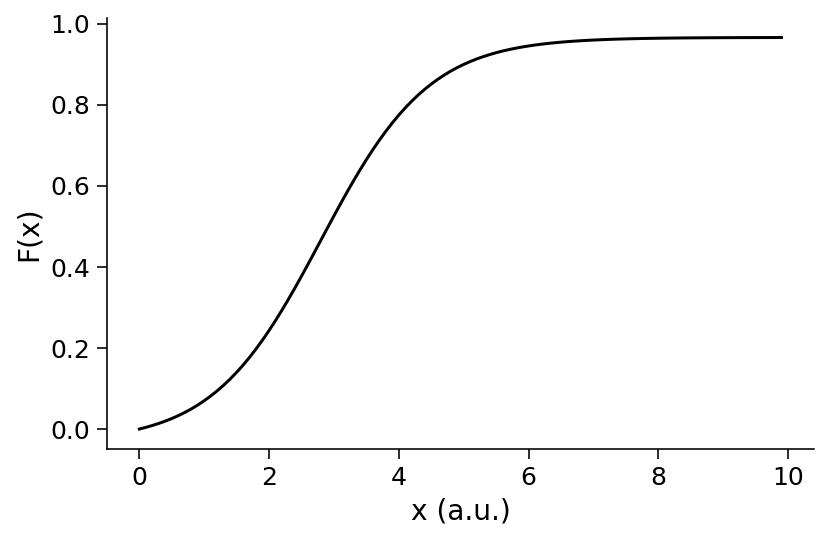

In [4]:
def F(x, a, theta):
  """
  Population activation function.

  Args:
    x (float): the population input
    a (float): the gain of the function
    theta (float): the threshold of the function

  Returns:
    float: the population activation response F(x) for input x
  """


  # Define the sigmoidal transfer function f = F(x)
  f = 1/(1+np.exp(-a*(x-theta))) - 1/(1+np.exp(a*theta))

  return f


# Set parameters
pars = default_pars_single()  # get default parameters
x = np.arange(0, 10, .1)      # set the range of input

# Compute transfer function
f = F(x, pars['a'], pars['theta'])

# Visualize
plot_fI(x, f)

In [5]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def interactive_plot_FI(a, theta):
  """
  Population activation function.

  Expecxts:
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    plot the F-I curve with give parameters
  """

  # set the range of input
  x = np.arange(0, 10, .1)
  plt.figure()
  plt.plot(x, F(x, a, theta), 'k')
  plt.xlabel('x (a.u.)', fontsize=14)
  plt.ylabel('F(x)', fontsize=14)
  plt.show()


_ = widgets.interact(interactive_plot_FI, a=(0.3, 3, 0.3), theta=(2, 4, 0.2))

interactive(children=(FloatSlider(value=1.5, description='a', max=3.0, min=0.3, step=0.3), FloatSlider(value=3…

In [6]:
# @markdown *Execute this cell to enable the single population rate model simulator: `simulate_single`*


def simulate_single(pars):
  """
  Simulate an excitatory population of neurons

  Args:
    pars   : Parameter dictionary

  Returns:
    rE     : Activity of excitatory population (array)

  Example:
    pars = default_pars_single()
    r = simulate_single(pars)
  """

  # Set parameters
  tau, a, theta = pars['tau'], pars['a'], pars['theta']
  w = pars['w']
  I_ext = pars['I_ext']
  r_init = pars['r_init']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Initialize activity
  r = np.zeros(Lt)
  r[0] = r_init
  I_ext = I_ext * np.ones(Lt)

  # Update the E activity
  for k in range(Lt - 1):
      dr = dt / tau * (-r[k] + F(w * r[k] + I_ext[k], a, theta))
      r[k+1] = r[k] + dr

  return r

help(simulate_single)

Help on function simulate_single in module __main__:

simulate_single(pars)
    Simulate an excitatory population of neurons
    
    Args:
      pars   : Parameter dictionary
    
    Returns:
      rE     : Activity of excitatory population (array)
    
    Example:
      pars = default_pars_single()
      r = simulate_single(pars)



In [7]:
# @title

# @markdown Make sure you execute this cell to enable the widget!

# get default parameters
pars = default_pars_single(T=20.)


def Myplot_E_diffI_difftau(I_ext, tau):
  # set external input and time constant
  pars['I_ext'] = I_ext
  pars['tau'] = tau

  # simulation
  r = simulate_single(pars)
    # ri + (F(I)-ri) - ri*(1-exp(-tau*t))
  # Analytical Solution
  r_ana = (pars['r_init']
           + (F(I_ext, pars['a'], pars['theta'])
           - pars['r_init']) * (1. - np.exp(-pars['range_t'] / pars['tau'])))

  # plot
  plt.figure()
  plt.plot(pars['range_t'], r, 'b', label=r'$r_{\mathrm{sim}}$(t)', alpha=0.5,
           zorder=1)
  plt.plot(pars['range_t'], r_ana, 'b--', lw=5, dashes=(2, 2),
           label=r'$r_{\mathrm{ana}}$(t)', zorder=2)
  plt.plot(pars['range_t'],
           F(I_ext, pars['a'], pars['theta']) * np.ones(pars['range_t'].size),
           'k--', label=r'$F(I_{\mathrm{ext}})$')
  plt.xlabel('t (ms)', fontsize=16.)
  plt.ylabel('Activity r(t)', fontsize=16.)
  plt.legend(loc='best', fontsize=14.)
  plt.show()


_ = widgets.interact(Myplot_E_diffI_difftau, I_ext=(0.0, 10., 1.),
                     tau=(1., 5., 0.2))

interactive(children=(FloatSlider(value=5.0, description='I_ext', max=10.0, step=1.0), FloatSlider(value=3.0, …

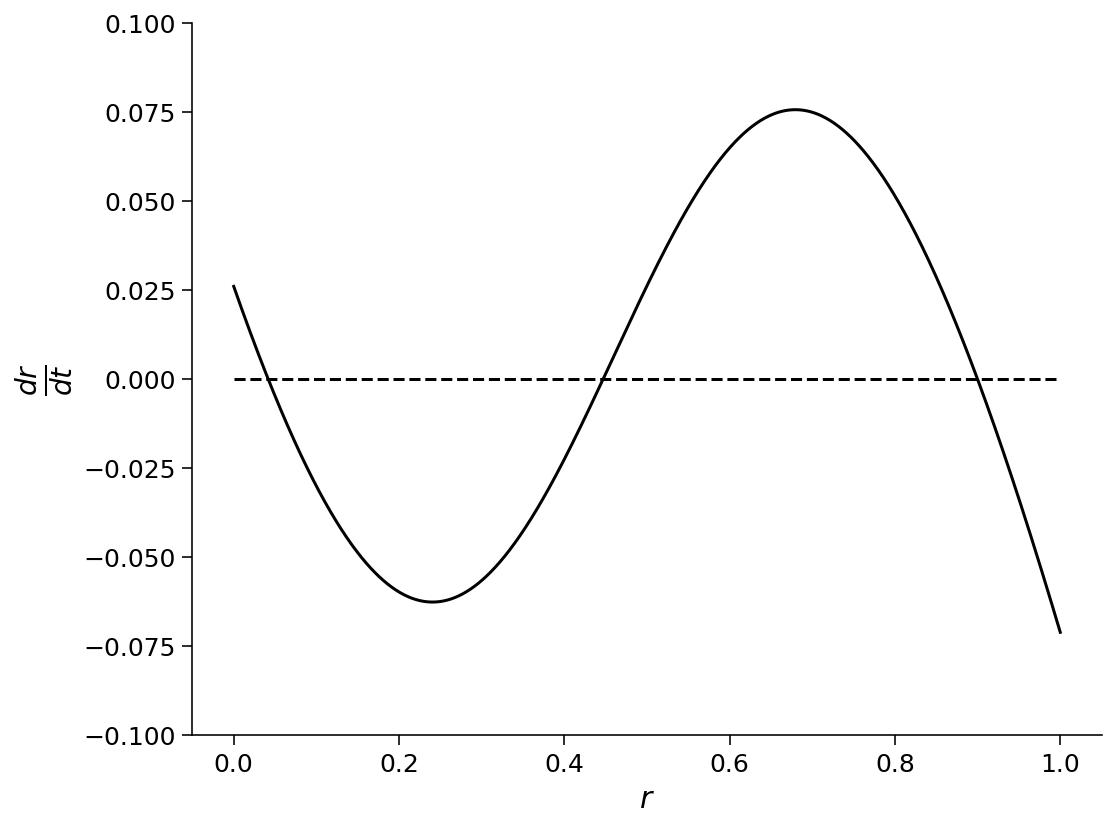

In [10]:
def compute_drdt(r, I_ext, w, a, theta, tau, **other_pars) -> None:
  """Given parameters, compute dr/dt as a function of r.

  Args:
    r (1D array) : Average firing rate of the excitatory population
    I_ext, w, a, theta, tau (numbers): Simulation parameters to use
    other_pars : Other simulation parameters are unused by this function

  Returns
    drdt function for each value of r
  """


  # Calculate drdt
  drdt = (-r + F((w*r + I_ext),a,theta))/tau

  return drdt


# Define a vector of r values and the simulation parameters
r = np.linspace(0, 1, 1000)
pars = default_pars_single(I_ext=0.5, w=5)

# Compute dr/dt
drdt = compute_drdt(r, **pars)

# Visualize
plot_dr_r(r, drdt)

In [11]:
# @markdown *Execute this cell to enable the fixed point functions*

def my_fp_single(r_guess, a, theta, w, I_ext, **other_pars):
  """
  Calculate the fixed point through drE/dt=0

  Args:
    r_guess  : Initial value used for scipy.optimize function
    a, theta, w, I_ext : simulation parameters

  Returns:
    x_fp    : value of fixed point
  """
  # define the right hand of E dynamics
  def my_WCr(x):
    r = x
    drdt = (-r + F(w * r + I_ext, a, theta))
    y = np.array(drdt)

    return y

  x0 = np.array(r_guess)
  x_fp = opt.root(my_WCr, x0).x.item()

  return x_fp


def check_fp_single(x_fp, a, theta, w, I_ext, mytol=1e-4, **other_pars):
  """
   Verify |dr/dt| < mytol

  Args:
    fp      : value of fixed point
    a, theta, w, I_ext: simulation parameters
    mytol   : tolerance, default as 10^{-4}

  Returns :
    Whether it is a correct fixed point: True/False
  """
  # calculate Equation(3)
  y = x_fp - F(w * x_fp + I_ext, a, theta)

  # Here we set tolerance as 10^{-4}
  return np.abs(y) < mytol


def my_fp_finder(pars, r_guess_vector, mytol=1e-4):
  """
  Calculate the fixed point(s) through drE/dt=0

  Args:
    pars    : Parameter dictionary
    r_guess_vector  : Initial values used for scipy.optimize function
    mytol   : tolerance for checking fixed point, default as 10^{-4}

  Returns:
    x_fps   : values of fixed points

  """
  x_fps = []
  correct_fps = []
  for r_guess in r_guess_vector:
    x_fp = my_fp_single(r_guess, **pars)
    if check_fp_single(x_fp, **pars, mytol=mytol):
      x_fps.append(x_fp)

  return x_fps

help(my_fp_finder)

Help on function my_fp_finder in module __main__:

my_fp_finder(pars, r_guess_vector, mytol=0.0001)
    Calculate the fixed point(s) through drE/dt=0
    
    Args:
      pars    : Parameter dictionary
      r_guess_vector  : Initial values used for scipy.optimize function
      mytol   : tolerance for checking fixed point, default as 10^{-4}
    
    Returns:
      x_fps   : values of fixed points



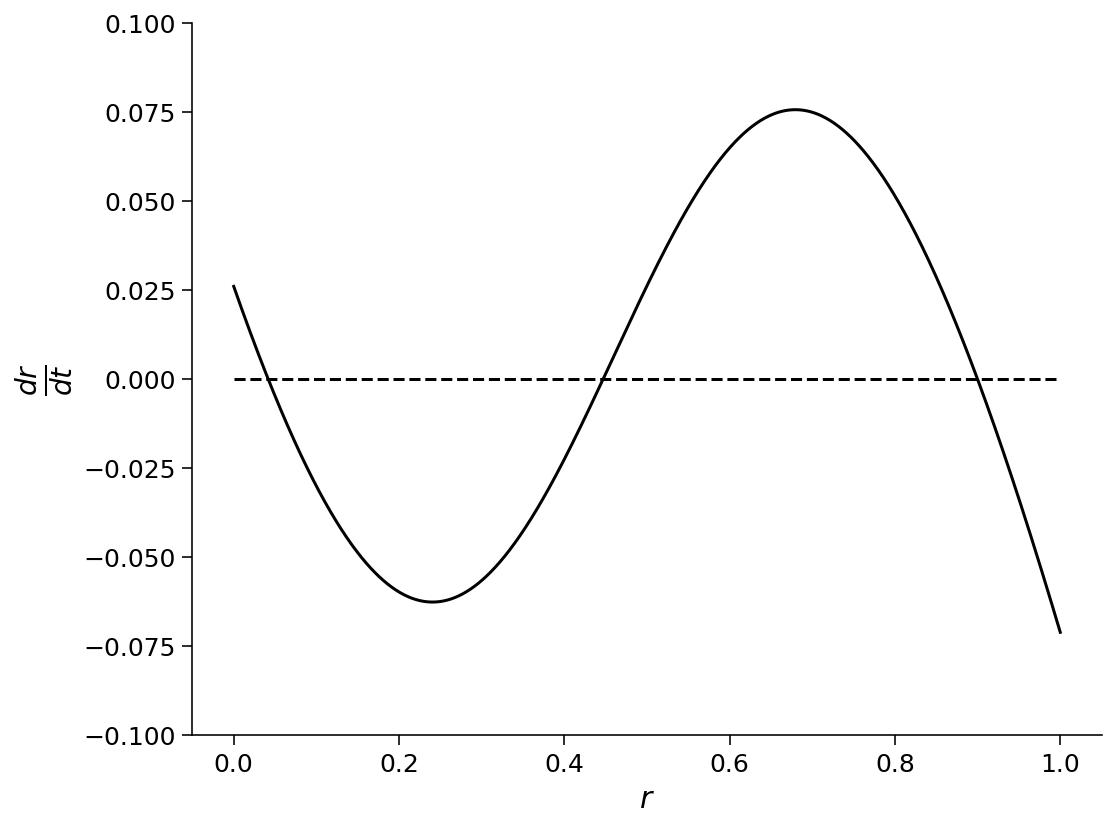

In [12]:
# Set parameters
r = np.linspace(0, 1, 1000)
pars = default_pars_single(I_ext=0.5, w=5)
# TODO for students:
# Define initial values close to the intersections of drdt and y=0
# (How many initial values? Hint: How many times do the two lines intersect?)
# Calculate the fixed point with these initial values and plot them
# Compute dr/dt
drdt = compute_drdt(r, **pars)

# Initial guesses for fixed points
r_guess_vector = r[drdt == 0]

# Find fixed point numerically
x_fps = my_fp_finder(pars, r_guess_vector)

# Visualize
plot_dr_r(r, drdt, x_fps)

In [13]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def plot_intersection_single(w, I_ext):
  # set your parameters
  pars = default_pars_single(w=w, I_ext=I_ext)

  # find fixed points
  r_init_vector = [0, .4, .9]
  x_fps = my_fp_finder(pars, r_init_vector)

  # plot
  r = np.linspace(0, 1., 1000)
  drdt = (-r + F(w * r + I_ext, pars['a'], pars['theta'])) / pars['tau']

  plot_dr_r(r, drdt, x_fps)

_ = widgets.interact(plot_intersection_single, w=(1, 7, 0.2),
                     I_ext=(0, 3, 0.1))
                     

interactive(children=(FloatSlider(value=4.0, description='w', max=7.0, min=1.0, step=0.2), FloatSlider(value=1…

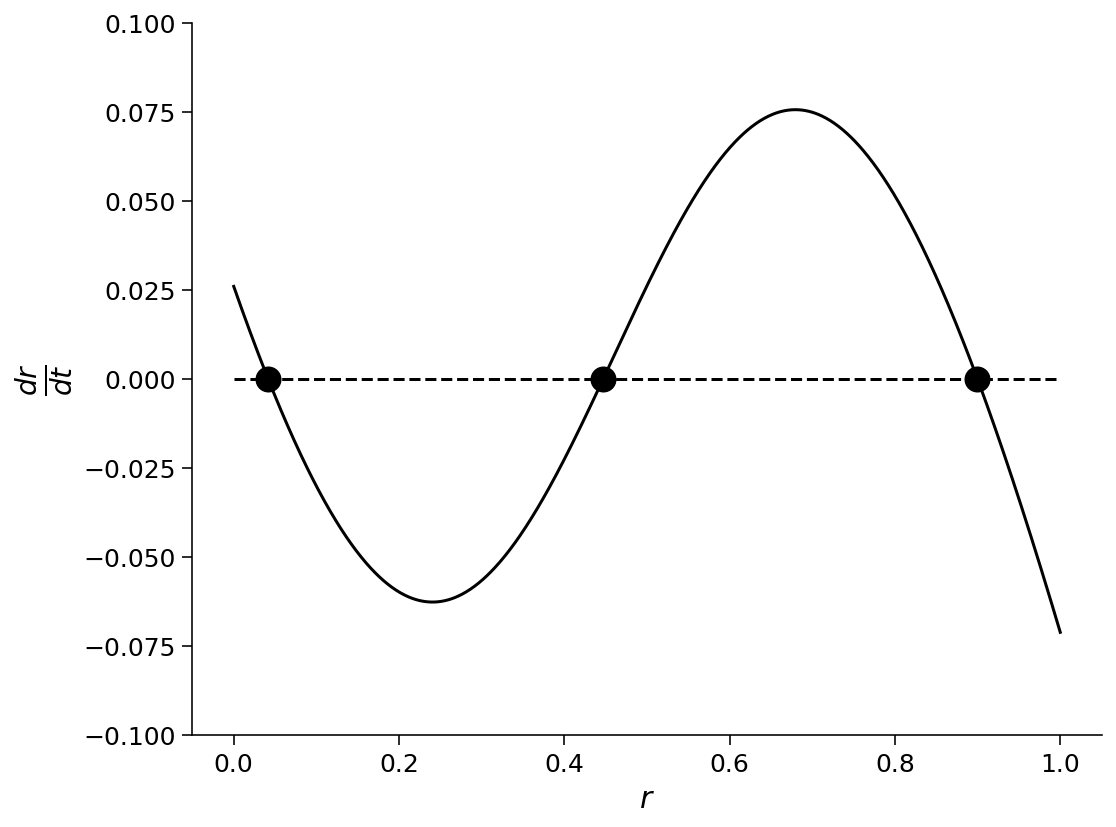

In [14]:
# @markdown Execute to visualize dr/dt

def plot_intersection_single(w, I_ext):
  # set your parameters
  pars = default_pars_single(w=w, I_ext=I_ext)

  # find fixed points
  r_init_vector = [0, .4, .9]
  x_fps = my_fp_finder(pars, r_init_vector)

  # plot
  r = np.linspace(0, 1., 1000)
  drdt = (-r + F(w * r + I_ext, pars['a'], pars['theta'])) / pars['tau']

  plot_dr_r(r, drdt, x_fps)

plot_intersection_single(w = 5.0, I_ext = 0.5)

In [15]:
# @markdown Make sure you execute this cell to enable the widget!

pars = default_pars_single(w=5.0, I_ext=0.5)

def plot_single_diffEinit(r_init):
  pars['r_init'] = r_init
  r = simulate_single(pars)

  plt.figure()
  plt.plot(pars['range_t'], r, 'b', zorder=1)
  plt.plot(0, r[0], 'bo', alpha=0.7, zorder=2)
  plt.xlabel('t (ms)', fontsize=16)
  plt.ylabel(r'$r(t)$', fontsize=16)
  plt.ylim(0, 1.0)
  plt.show()


_ = widgets.interact(plot_single_diffEinit, r_init=(0, 1, 0.02))

interactive(children=(FloatSlider(value=0.0, description='r_init', max=1.0, step=0.02), Output()), _dom_classe…

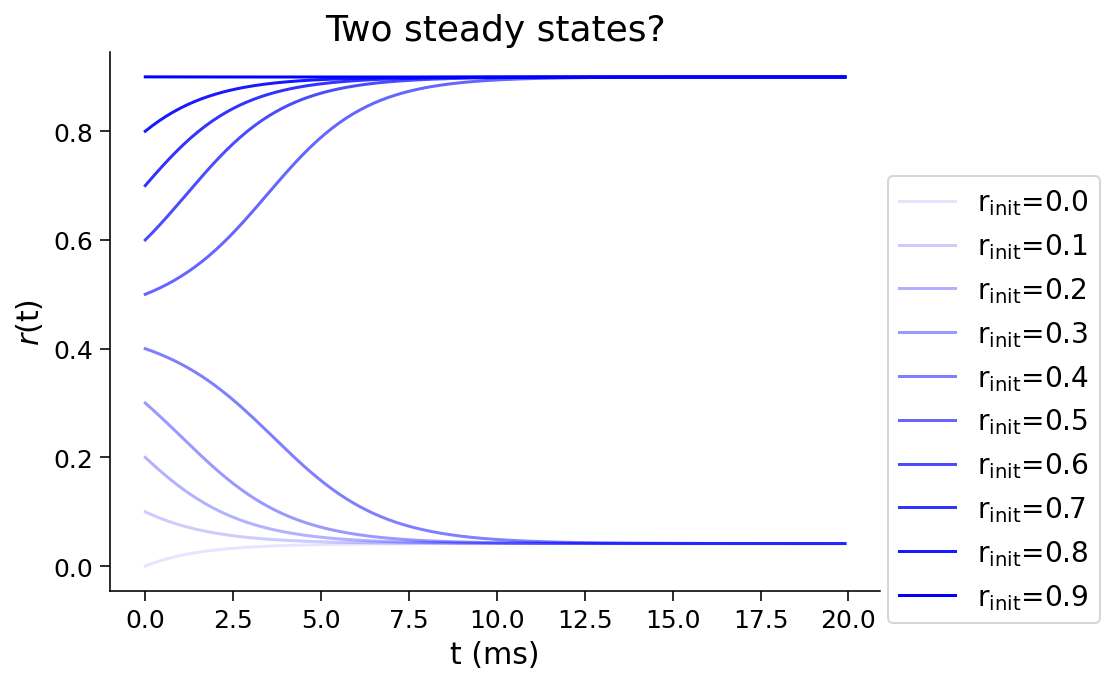

In [20]:
# @markdown Execute this cell to see the trajectories!

pars = default_pars_single()
pars['w'] = 5.0
pars['I_ext'] = 0.5

plt.figure(figsize=(8, 5))
for ie in range(10):
  pars['r_init'] = 0.1 * ie  # set the initial value
  r = simulate_single(pars)  # run the simulation

  # plot the activity with given initial
  plt.plot(pars['range_t'], r, 'b', alpha=0.1 + 0.1 * ie,
           label=r'r$_{\mathrm{init}}$=%.1f' % (0.1 * ie))

plt.xlabel('t (ms)')
plt.title('Two steady states?')
plt.ylabel(r'$r$(t)')
plt.legend(loc=[1.01, -0.06], fontsize=14)
plt.show()

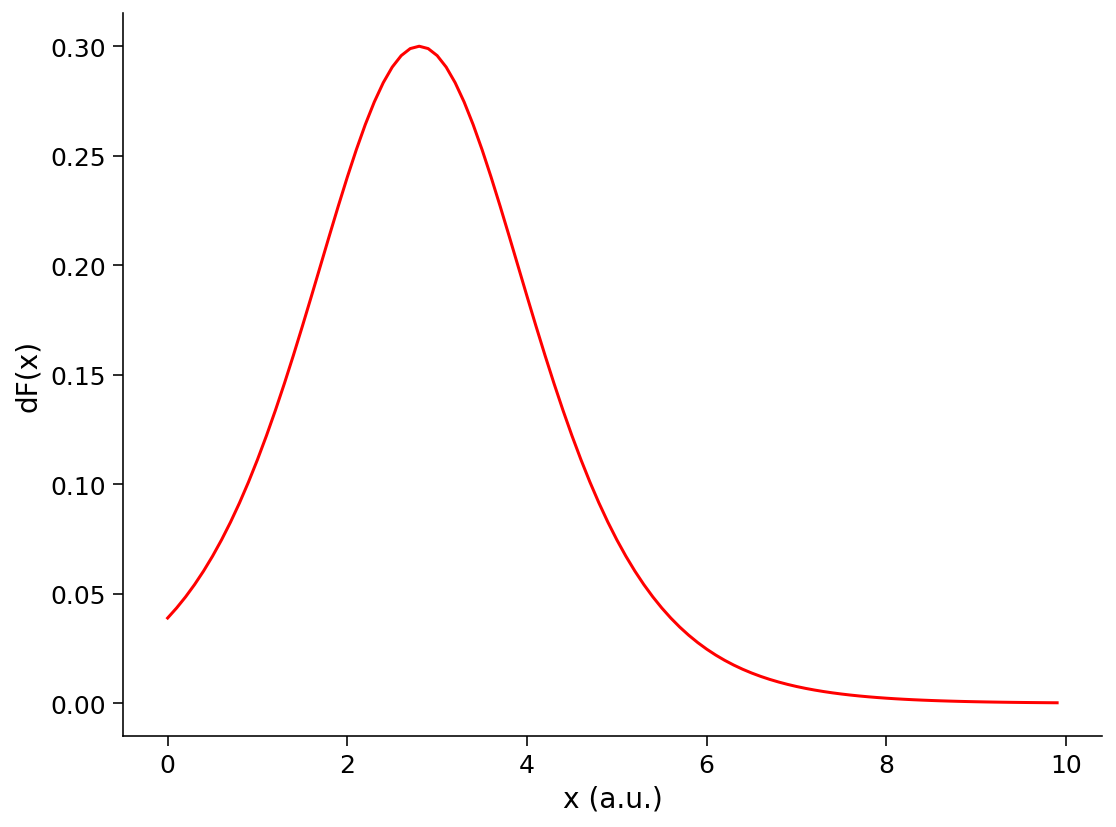

In [21]:
# @markdown Execute this cell to enable helper function `dF` and visualize derivative

def dF(x, a, theta):
  """
  Population activation function.

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    dFdx  : the population activation response F(x) for input x
  """

  # Calculate the population activation
  dFdx = a * np.exp(-a * (x - theta)) * (1 + np.exp(-a * (x - theta)))**-2

  return dFdx

# Set parameters
pars = default_pars_single()  # get default parameters
x = np.arange(0, 10, .1)      # set the range of input

# Compute derivative of transfer function
df = dF(x, pars['a'], pars['theta'])

# Visualize
plot_dFdt(x, df)

In [22]:
def eig_single(fp, tau, a, theta, w, I_ext, **other_pars):
  """
  Args:
    fp   : fixed point r_fp
    tau, a, theta, w, I_ext : Simulation parameters

  Returns:
    eig : eigenvalue of the linearized system
  """

  # Compute the eigenvalue
  eig = (-1 + w*dF(w*fp + I_ext ,a,theta))/tau

  return eig


# Find the eigenvalues for all fixed points
pars = default_pars_single(w=5, I_ext=.5)
r_guess_vector = [0, .4, .9]
x_fp = my_fp_finder(pars, r_guess_vector)


for fp in x_fp:
  eig_fp = eig_single(fp, **pars)
  print(f'Fixed point1 at {fp:.3f} with Eigenvalue={eig_fp:.3f}')

Fixed point1 at 0.042 with Eigenvalue=-0.583
Fixed point1 at 0.447 with Eigenvalue=0.498
Fixed point1 at 0.900 with Eigenvalue=-0.626


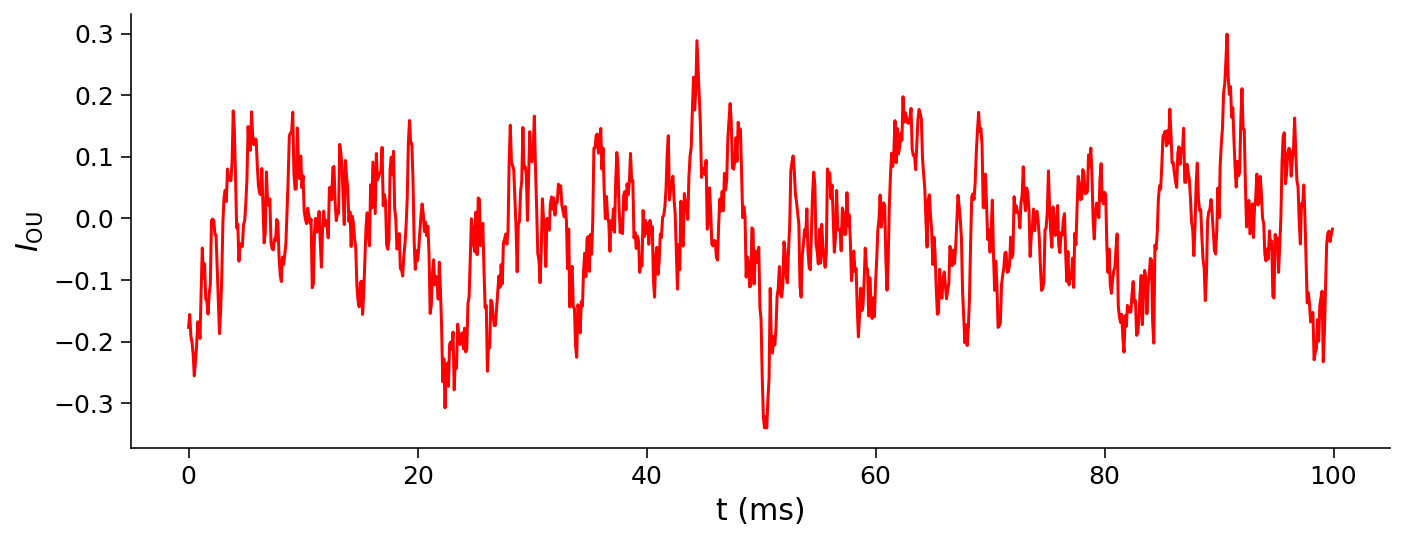

In [24]:
# @markdown Execute to get helper function `my_OU` and visualize OU process


def my_OU(pars, sig, myseed=False):
  """
  A functions that generates Ornstein-Uhlenback process

  Args:
    pars       : parameter dictionary
    sig        : noise amplitute
    myseed     : random seed. int or boolean

  Returns:
    I          : Ornstein-Uhlenbeck input current
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tau_ou = pars['tau_ou']  # [ms]

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # Initialize
  noise = np.random.randn(Lt)
  I_ou = np.zeros(Lt)
  I_ou[0] = noise[0] * sig

  # generate OU
  for it in range(Lt - 1):
    I_ou[it + 1] = (I_ou[it]
                    + dt / tau_ou * (0. - I_ou[it])
                    + np.sqrt(2 * dt / tau_ou) * sig * noise[it + 1])

  return I_ou


pars = default_pars_single(T=100)
pars['tau_ou'] = 1.  # [ms]
sig_ou = 0.1
I_ou = my_OU(pars, sig=sig_ou, myseed=2020)
plt.figure(figsize=(10, 4))
plt.plot(pars['range_t'], I_ou, 'r')
plt.xlabel('t (ms)')
plt.ylabel(r'$I_{\mathrm{OU}}$')
plt.show()

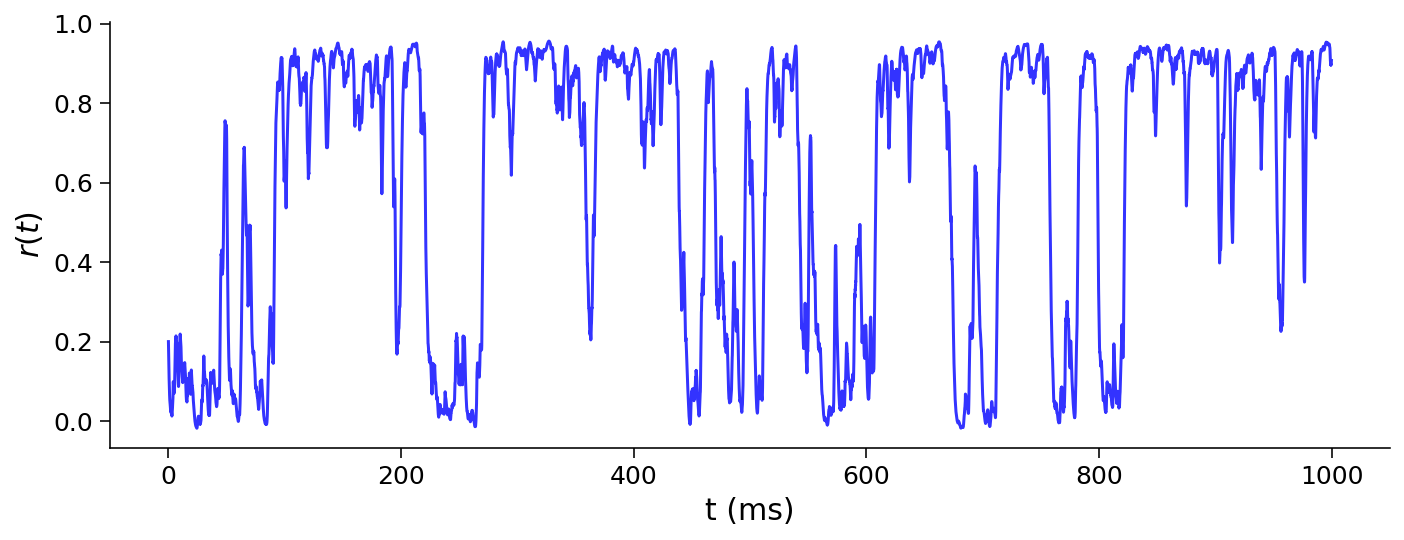

In [25]:
# @markdown Execute this cell to simulate E population with OU inputs

pars = default_pars_single(T=1000)
pars['w'] = 5.0
sig_ou = 0.7
pars['tau_ou'] = 1.  # [ms]
pars['I_ext'] = 0.56 + my_OU(pars, sig=sig_ou, myseed=2020)

r = simulate_single(pars)

plt.figure(figsize=(10, 4))
plt.plot(pars['range_t'], r, 'b', alpha=0.8)
plt.xlabel('t (ms)')
plt.ylabel(r'$r(t)$')
plt.show()